<a href="https://colab.research.google.com/github/samuvale95/bioinformatics/blob/samuele/Bioinformatic_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing requirements

In [41]:
!pip install scikit-learn
!pip install barplots
!pip install plot_keras_history
!pip install epigenomic_dataset>=1.1.7
!pip install ucsc_genomes_downloader>=1.1.22
!pip install keras_bed_sequence>=1.1.5
!pip install ray
!pip install seaborn
!pip install minepy
!pip install boruta
!pip install prince
!pip install cmake
!pip install multicoretsne
!pip install silence_tensorflow>=1.1.1
!pip install tsnecuda
!pip install extra_keras_metrics

  Created wheel for extra-keras-metrics: filename=extra_keras_metrics-2.0.5-py3-none-any.whl size=14204 sha256=ad62eabbc73e5c188282891b4951c66d59eeb7c9c4c2f5fc78380cc9aebc87c4
  Stored in directory: /root/.cache/pip/wheels/63/4e/93/db952d2851565bce46c84fc138a87c25119540133b5a2fda31
Successfully built extra-keras-metrics


#Import packages

In [42]:
from typing import Dict, List, Tuple, Optional
from cache_decorator import Cache
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.colors import ListedColormap, LogNorm
from multiprocessing import cpu_count, Pool
import matplotlib.pyplot as plt
from epigenomic_dataset.utils import get_cell_lines
from typing import Tuple
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Concatenate, Layer
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D, GlobalMaxPool1D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from extra_keras_metrics import get_complete_binary_metrics

# Import Epigenomic Data

In [3]:
cell_line='MCF-7'

In [4]:
from epigenomic_dataset import active_promoters_vs_inactive_promoters

X, y = active_promoters_vs_inactive_promoters(cell_line=cell_line)

In [5]:
help(active_promoters_vs_inactive_promoters)

Help on function active_promoters_vs_inactive_promoters in module epigenomic_dataset.load_tasks:

active_promoters_vs_inactive_promoters(cell_line: str = 'K562', assembly: str = 'hg38', dataset: str = 'fantom', metric: str = 'mean', window_size: int = 256, root: str = 'datasets', binarize: bool = False, min_active_tpm_value: float = 1, max_inactive_tpm_value: float = 1, verbose: int = 2)
    Return epigenomic data and labels for given parameters.
    
    Parameters
    ----------------------------------------
    cell_line: str = "K562",
        Cell line to consider. By default K562.
        Currently available cell lines are
        listed in the repository README file.
    assembly: str,
        The genomic assembly of the data to be retrieved.
    dataset: str = "fantom",
        Dataset to consider. By default fantom.
        Currently available datasets are
        listed in the repository README file.
    metric: str = "mean",
        The metric to load.
    window_size: int = 

In [6]:
X

chrom                              SNIP1  CREB1  NRF1  ...  SIN3A  E2F4  E4F1
chrom chromStart chromEnd  strand                      ...                   
chr1  628964     629220    +        0.43   0.27  0.14  ...   0.28  0.00  0.17
      629013     629269    +        0.55   0.21  0.23  ...   0.40  0.00  0.22
      629642     629898    +        0.06   0.18  0.22  ...   0.26  0.31  0.00
      629847     630103    +        0.25   0.87  0.78  ...   0.57  0.59  0.41
      629905     630161    +        0.26   1.07  0.87  ...   0.69  0.45  0.67
...                                  ...    ...   ...  ...    ...   ...   ...
chrX  154441877  154442133 +        1.27   0.71  1.16  ...   0.77  0.47  0.70
      154584927  154585183 +        0.00   0.00  0.00  ...   0.00  0.00  0.00
chrY  1452882    1453138   -        0.00   0.00  0.00  ...   0.00  0.00  0.00
      2500959    2501215   -        0.00   0.00  0.00  ...   0.00  0.00  0.00
      14055973   14056229  +        0.00   0.00  0.00  ...   0.00  0.00  0.00

[99881 rows x 117 columns]

In [7]:
X.describe()

chrom         SNIP1         CREB1  ...          E2F4          E4F1
count  99881.000000  99881.000000  ...  99881.000000  99881.000000
mean       1.002477      5.364149  ...      0.920354      1.153994
std        1.401351     24.737295  ...      1.488773      4.419051
min        0.000000      0.000000  ...      0.000000      0.000000
25%        0.550000      0.520000  ...      0.480000      0.510000
50%        0.860000      1.020000  ...      0.740000      0.820000
75%        1.240000      2.550000  ...      1.050000      1.180000
max       90.570000   1115.880000  ...     51.060000    228.320000

[8 rows x 117 columns]

In [8]:
y

MCF7
chrom chromStart chromEnd  strand          
chr1  628964     629220    +       0.000000
      629013     629269    +       0.000000
      629642     629898    +       0.000000
      629847     630103    +       0.000000
      629905     630161    +       0.330364
...                                     ...
chrX  154441877  154442133 +       0.000000
      154584927  154585183 +       0.000000
chrY  1452882    1453138   -       0.000000
      2500959    2501215   -       0.000000
      14055973   14056229  +       0.000000

[99881 rows x 1 columns]

In [9]:
y.describe()

MCF7
count  99881.000000
mean       7.517577
std      152.394896
min        0.000000
25%        0.000000
50%        0.000000
75%        0.991093
max    41587.260334

# Data Cleaning

In [10]:
X.shape[0] / X.shape[1]

853.6837606837607

In [11]:
X.isna().sum().sum()

182

In [12]:
y.isna().sum().sum()

0

N.B. try different weights's values 

In [13]:
from sklearn.impute import KNNImputer

def knn_imputation(df:pd.DataFrame, neighbours:int=5, weights:str='uniform')->pd.DataFrame:
    """Return provided dataframe with NaN imputed using knn.
    
    Parameters
    --------------------
    df:pd.DataFrame,
        The dataframe to impute.
    neighbours:int=5,
        The number of neighbours to consider.
    weights:str='uniform',
        Weight function used in prediction.
        
    Returns
    --------------------
    The dataframe with the NaN values imputed.
    """
    return pd.DataFrame(
        KNNImputer(n_neighbors=neighbours, weights=weights).fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [14]:
X = knn_imputation(X)

In [15]:
X.isna().sum().sum()

0

In [16]:
def drop_constant_features(df:pd.DataFrame)->pd.DataFrame:
    """Return DataFrame without constant features."""
    return df.loc[:, (df != df.iloc[0]).any()]

In [17]:
X_dropped = drop_constant_features(X)

Check if some features hes been drop

In [18]:
X.shape != X_dropped.shape

False

In [19]:
from sklearn.preprocessing import RobustScaler

def robust_zscoring(df:pd.DataFrame)->pd.DataFrame:
    """Return given dataframe scaled using robust z-scoring."""
    return pd.DataFrame(
        RobustScaler().fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [20]:
X = robust_zscoring(X)

In [39]:
X.describe()

chrom         SNIP1         CREB1  ...          E2F4          E4F1
count  99881.000000  99881.000000  ...  99881.000000  99881.000000
mean       0.206488      2.139975  ...      0.316410      0.498498
std        2.030944     12.185860  ...      2.611882      6.595598
min       -1.246377     -0.502463  ...     -1.298246     -1.223881
25%       -0.449275     -0.246305  ...     -0.456140     -0.462687
50%        0.000000      0.000000  ...      0.000000      0.000000
75%        0.550725      0.753695  ...      0.543860      0.537313
max      130.014493    549.192118  ...     88.280702    339.552239

[8 rows x 117 columns]

In [21]:
p_value_threshold = 0.01
correlation_threshold = 0.05

# Class Balance (todo)

Features and Output correlation with Pearson and Spearman

In [22]:
not_correlated = list()

In [23]:
from scipy.stats import spearmanr

for feature in tqdm(X.columns, desc=f"Running Spearman test", dynamic_ncols=True, leave=False):
    correlation, p_value = spearmanr(X[feature].values.flatten(), y.values.flatten())
    if p_value > p_value_threshold:
        print(f"The feature {feature} does not correlate in a statistically significant manner with the output. p-value:{p_value} -- correlation:{correlation}")
        not_correlated.append(feature)

Running Spearman test:   0%|          | 0/117 [00:00<?, ?it/s]

In [24]:
not_correlated

[]

from scipy.stats import spearmanr

@Cache(
    cache_path="correlations/spearmanr/{_hash}.json",
    args_to_ignore=["X"]
)
def compute_spearmanr(
    X:pd.DataFrame,
    feature_left: str,
    feature_right: str,
    cell_line: str,
    region: str
) -> Dict:
    """Returns Spearman correlation.
    
    Implementative details
    ------------------------------
    We may need to recompute this value across
    multiple re-runs of the jupyter notebook,
    so since it takes a bit of time to do so we cache it.
    
    Parameters
    ----------------------
    X:pd.DataFrame,
        The epigenomic data.
    feature_left: str,
        The left features to compute pearson for.
    feature_right: str,
        The right features to compute pearson for.
    cell_line: str,
        The cell line.
    region: str,
        The cis-regulatory region of interest.
    """
    correlation, p_value = spearmanr(
        X[feature_left].values.flatten(),
        X[feature_right].values.flatten(),
    )
    return dict(
        correlation=correlation,
        p_value=p_value
    )

for feature_left in tqdm(X.columns, desc=f"Running Spearman test", dynamic_ncols=True, leave=False):
    for feature_right in X.columns:
        if feature_left >= feature_right:
            # Since the pearson correlation is simmetric, we do not need to check
            # for the entire squared matrix of features but the upper triangular one
            # is sufficient.
            continue
        pearson_result = compute_spearmanr(
            X,
            feature_left,
            feature_right,
            cell_line=cell_line,
            region="promoters"
        )
        if pearson_result["p_value"] < p_value_threshold and np.abs(pearson_result["correlation"]) > 0.95:
            correlation = pearson_result["correlation"]
            print(f"The feature {feature_left} is highly correlated with {feature_right} ({correlation}).")
            

In [25]:
from minepy import MINE

for feature in tqdm(not_correlated, desc=f"Running MINE test", dynamic_ncols=True, leave=False):
    mine = MINE()
    mine.compute_score(X[feature].values.ravel(), y.values.ravel())
    score = mine.mic()
    if score < correlation_threshold:
        print(f"The feature {feature} does not correlate in a statistically significant manner with the output.")

Running MINE test: 0it [00:00, ?it/s]

In [26]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from boruta import BorutaPy
from multiprocessing import cpu_count

@Cache(
    cache_path=[
        "boruta/kept_features_{_hash}.json",
        "boruta/discarded_features_{_hash}.json"
    ],
    args_to_ignore=[
        "X_train", "y_train"
    ]
)
def execute_boruta_feature_selection(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    holdout_number: int,
    regression: bool,
    task_name: str,
    max_iter: int = 100
):
    """Returns tuple with list of kept features and list of discared features.
    
    Parameters
    --------------------------
    X_train: pd.DataFrame,
        The data reserved for the input of the training of the Boruta model.
    y_train: np.ndarray,
        The data reserved for the output of the training of the Boruta model.
    holdout_number: int,
        The current holdout number.
    regression: bool,
        Whether the task is a binary classification one (False) or a regression one (True).
    task_name: str,
        The name of the task.
    max_iter: int = 100,
        Number of iterations to run Boruta for.
    """
    # According to the requested task we build either a random forest regressor
    # or a random forest classifier.
    if regression:
        model = RandomForestRegressor(n_jobs=cpu_count(), max_depth=5)
    else:
        model = RandomForestClassifier(n_jobs=cpu_count(), class_weight='balanced_subsample', max_depth=5)
    
    # Create the Boruta model
    boruta_selector = BorutaPy(
        # Defining the model that Boruta should use.
        model,
        # We leave the number of estimators to be decided by Boruta
        n_estimators='auto',
        verbose=False,
        alpha=0.05, # p_value
        # In practice one would run at least 100-200 times,
        # until all tentative features are exausted.
        max_iter=max_iter, 
        random_state=42,
    )
    # Fit the Boruta model
    boruta_selector.fit(X_train.values, y_train)
    
    # Get the kept features and discarded features
    kept_features = list(X_train.columns[boruta_selector.support_])
    discarded_features = list(X_train.columns[~boruta_selector.support_])
    
    # Filter out the unused featured.
    return kept_features, discarded_features

In [27]:
from ucsc_genomes_downloader import Genome

genome = Genome("hg38")

Loading chromosomes for genome hg38:   0%|          | 0/25 [00:00<?, ?it/s]

In [28]:
def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]

In [29]:
genome.bed_to_sequence(to_bed(y))

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


array(['AAATGGTCATCCATCCTTTGGCCCCAATACCTAAACTAAGGTCTATGAACAATAAGATGATTTTCTTCAGTGGGACTTTTTTGTTTAATATATTAGATTTGACCTTCAGCAAGGTCAAAGGGAGTCCGAACTAGTCTCAGGCTTCAACATCGAATACGCCGCAGGCCCCTTCGCCCTATTCTTCATAGCCGAATACACAAACATTATTATAATAAACACCCTCACCACTACAATCTTCCTAGGAACAACATATAAC',
       'CAATAAGATGATTTTCTTCAGTGGGACTTTTTTGTTTAATATATTAGATTTGACCTTCAGCAAGGTCAAAGGGAGTCCGAACTAGTCTCAGGCTTCAACATCGAATACGCCGCAGGCCCCTTCGCCCTATTCTTCATAGCCGAATACACAAACATTATTATAATAAACACCCTCACCACTACAATCTTCCTAGGAACAACATATAACGCACTCTCCCCTGAACTCTACACAACATATTTTGTCACCAAGACCCTAC',
       'AATCCCCTGGCCCAACCCGTCATCTACTCTACCATCTTTGCAGGCACACTCATCACAGCGCTAAGCTCGCACTGATTTTTTACCTGAGTAGGCCTAGAAATAAACATGCTAGCTTTTATTCCAGTTCTAACCAAAAAAATAAACCCTCGTTCCACAGAAGCTGCCATCAAGTATTTCCTCACGCAAGCAACCGCATCCATAATCCTTCTAATAGCTATCCTCTTCAACAATATACTCTCCGGACAATGAACCATAA',
       ...,
       'AGATTTATAACATATATGATATAATCATGGGGGGGGTGAATAATTGAGACTTTATTCTTATAGAATTGTATTTTTATTTATTCTTATAGAATTGTATTTGACTTATATTCCTGACAATTCTTTTATAGAGTTATATTTGAATTGTATTCTTGCCAGGTGTCTTACTGAATTCTATTTGA

In [30]:
from keras_bed_sequence import BedSequence

np.array(BedSequence(
    genome,
    bed=to_bed(y),
    batch_size=1
))

array([[[[0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         ...,
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.]]],


       [[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         ...,
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.]]],


       [[[0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         ...,
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.]]],


       ...,


       [[[0., 0., 0., 1.],
         [0., 1., 0., 0.],
         [0., 0., 0., 1.],
         ...,
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.]]],


       [[[0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         ...,
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.]]],


       [[[0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
     

# Data visualization with t-SNE or PCA 

In [35]:
from sklearn.decomposition import PCA

@Cache(
    cache_path="decompositions/pca/{data_type}_{region}_{cell_line}_{metric}.pkl.gz",
    # We do not want to include the X variable into the hash
    args_to_ignore=["X"],
)
def get_pca_decomposition(
    X: pd.DataFrame,
    data_type: str,
    region: str,
    cell_line: str,
    metric: str,
    **kwargs
) -> pd.DataFrame:
    """Return the 2D TSNE decomposition of the given data."""
    return pd.DataFrame(
        PCA(n_components=2).fit_transform(X.values),
        index=X.index
    )

In [31]:
# Here we need to use the cached decomposition because computing
# TSNE decompositions can get very expensive computationally
# I provide the TSNE decomposition within the course repository.
@Cache(
    cache_path="decompositions/tsne/{data_type}_{region}_{cell_line}_{metric}.pkl.gz",
    # We do not want to include the X variable into the hash
    args_to_ignore=["X"],
)
def get_tsne_decomposition(
    X: pd.DataFrame,
    data_type: str,
    region: str,
    cell_line: str,
    metric: str,
)->pd.DataFrame:
    """Return the 2D TSNE decomposition of the given data."""
    # The import of the TSNECUDA is within the method and not
    # outside because it is hard to install the package
    from tsnecuda import TSNE
    return pd.DataFrame(
        TSNE(
            # Better performance may be achieved with cosine distance,
            # but currently TSNECUDA does not support other metrics.
            # Expecially for the sequence data, cosine distances may be foundamental
            # to get a semantically significant decomposition.
            verbose=True
        ).fit_transform(X.values),
        index=X.index
    )

In [32]:
def scatter_with_heatmap(
    decomposition: pd.DataFrame,
    scores: np.ndarray,
    figure: Figure,
    ax: Axes
):
    scatter = ax.scatter(
        *decomposition.values.T,
        c=scores,
        cmap=plt.cm.get_cmap('RdYlBu'),
        norm=LogNorm(),
        s=3
    )
    color_bar = figure.colorbar(scatter, ax=ax)

Computing decompositions:   0%|          | 0/7 [00:00<?, ?it/s]

Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Decomposition method:   0%|          | 0/1 [00:00<?, ?it/s]

Task:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Decomposition method:   0%|          | 0/1 [00:00<?, ?it/s]

Task:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Decomposition method:   0%|          | 0/1 [00:00<?, ?it/s]

Task:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Decomposition method:   0%|          | 0/1 [00:00<?, ?it/s]

Task:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Decomposition method:   0%|          | 0/1 [00:00<?, ?it/s]

Task:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Decomposition method:   0%|          | 0/1 [00:00<?, ?it/s]

Task:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Decomposition method:   0%|          | 0/1 [00:00<?, ?it/s]

Task:   0%|          | 0/2 [00:00<?, ?it/s]

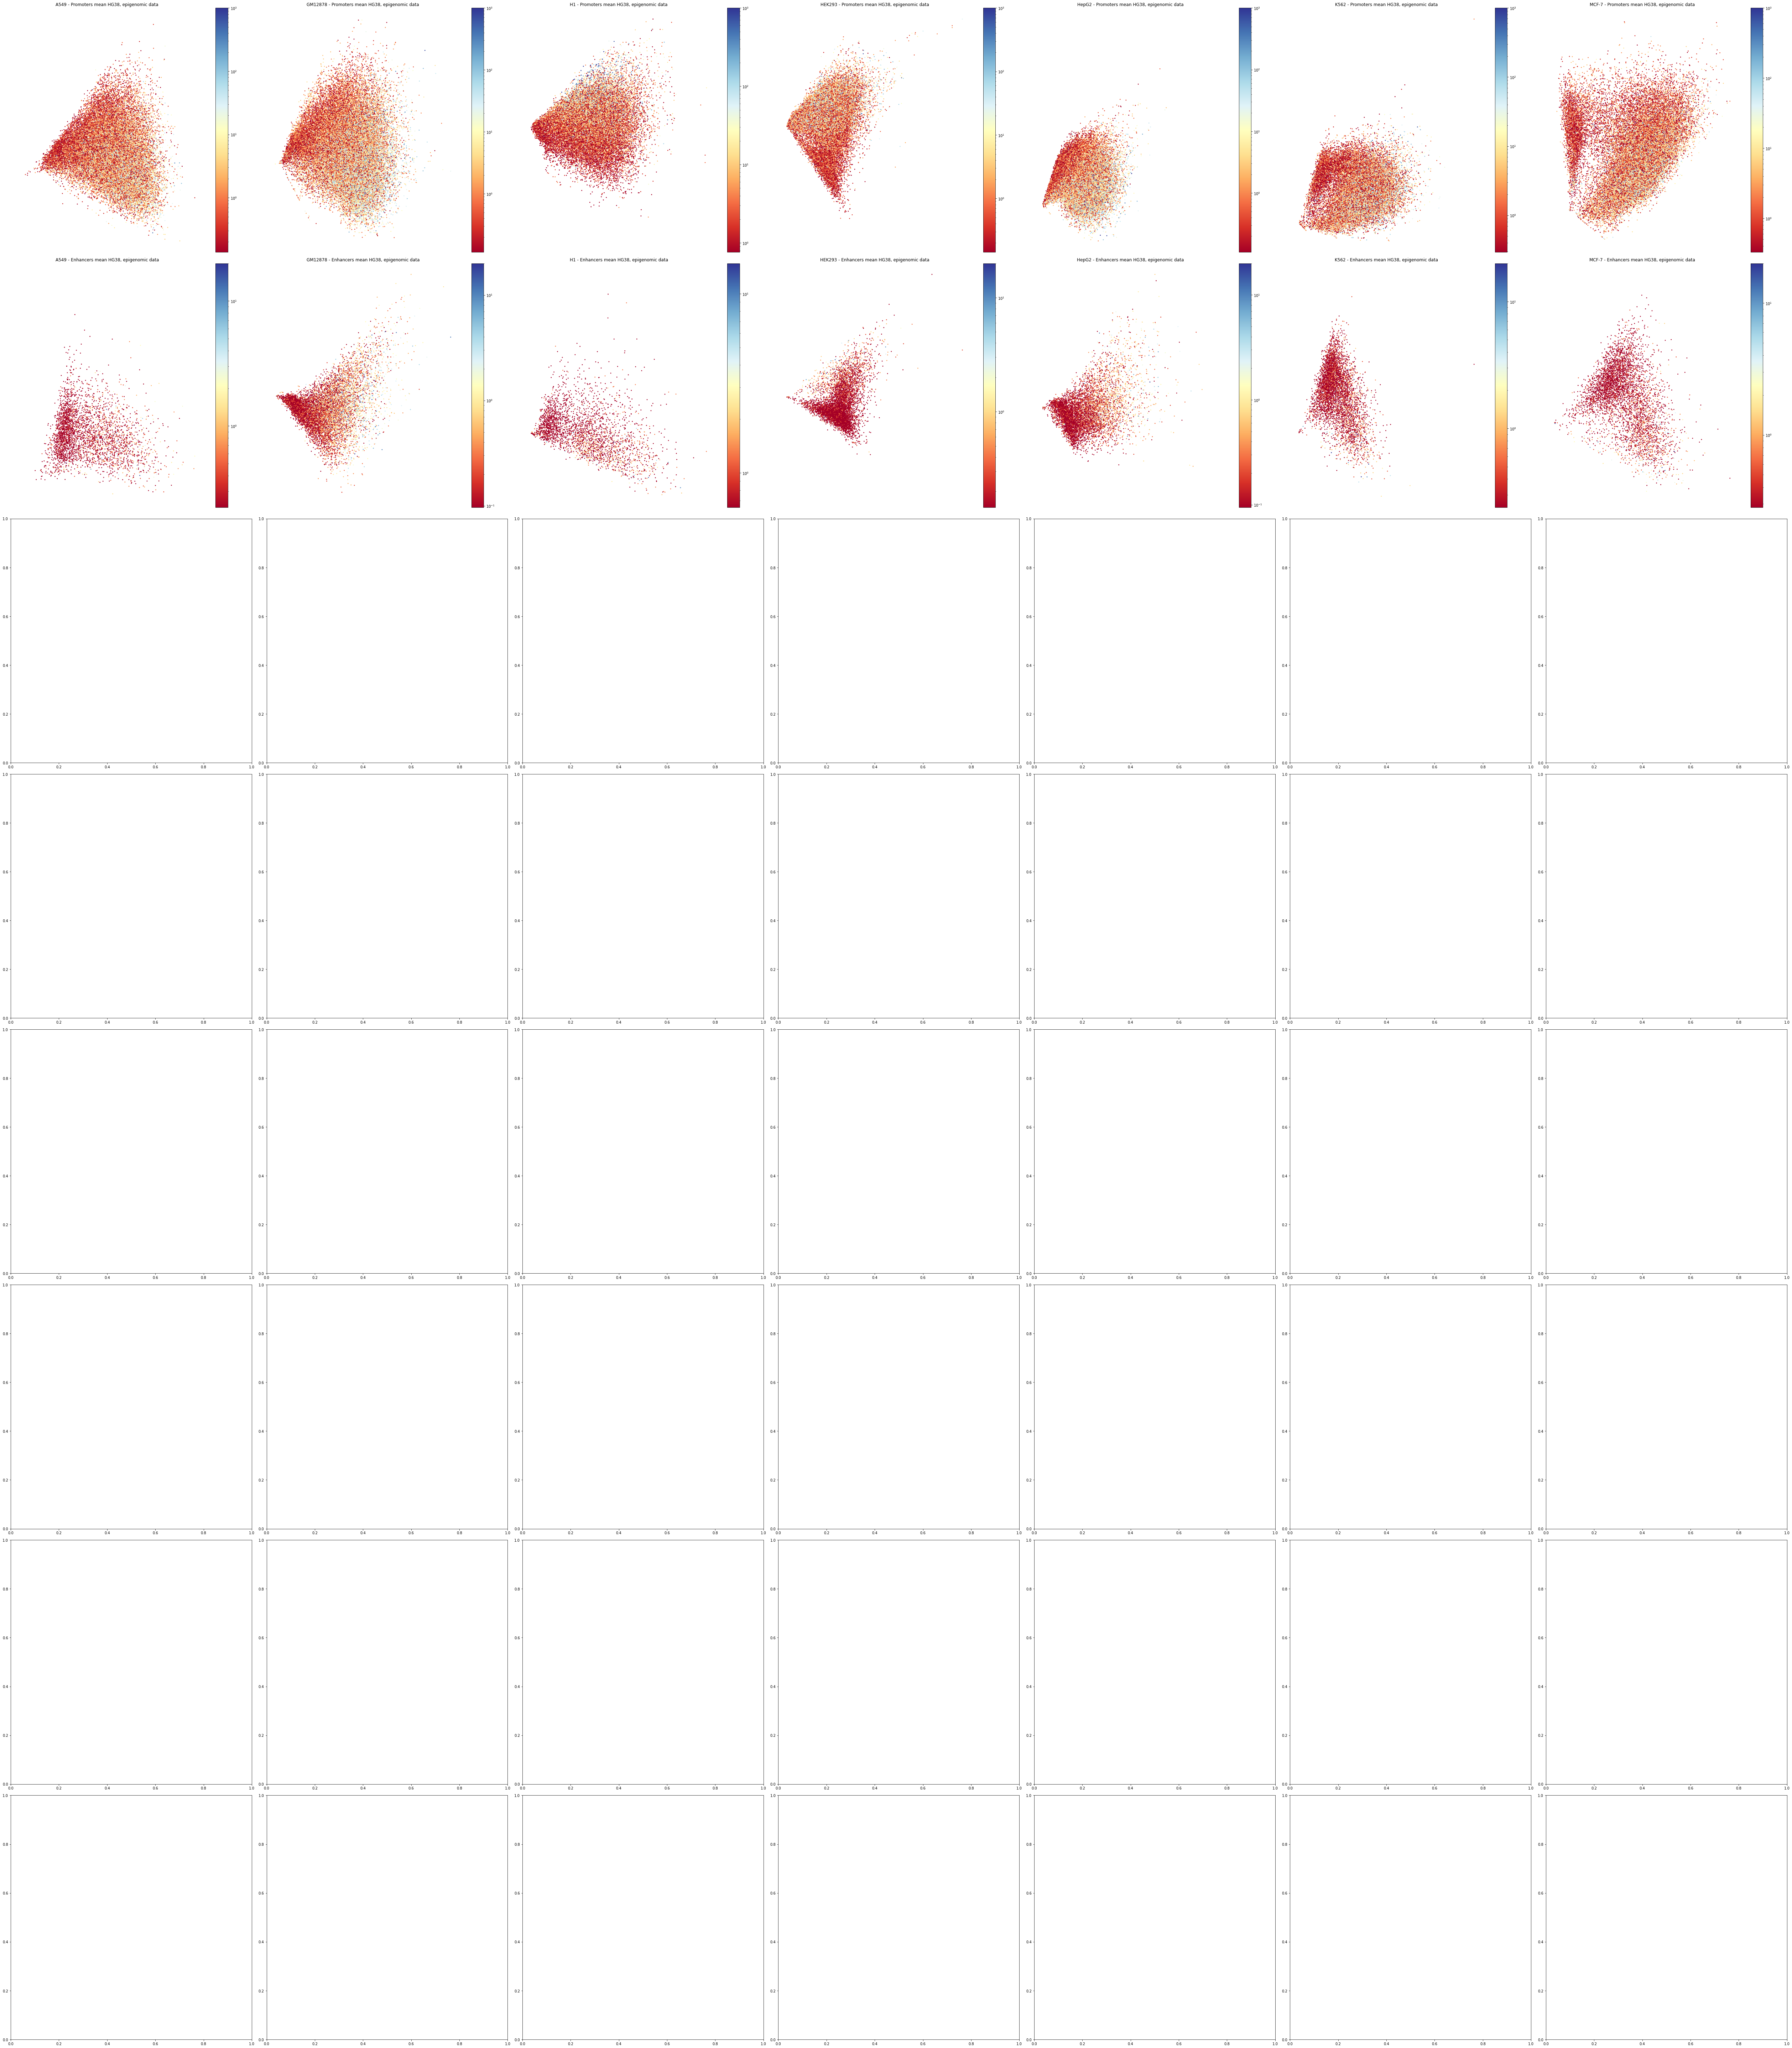

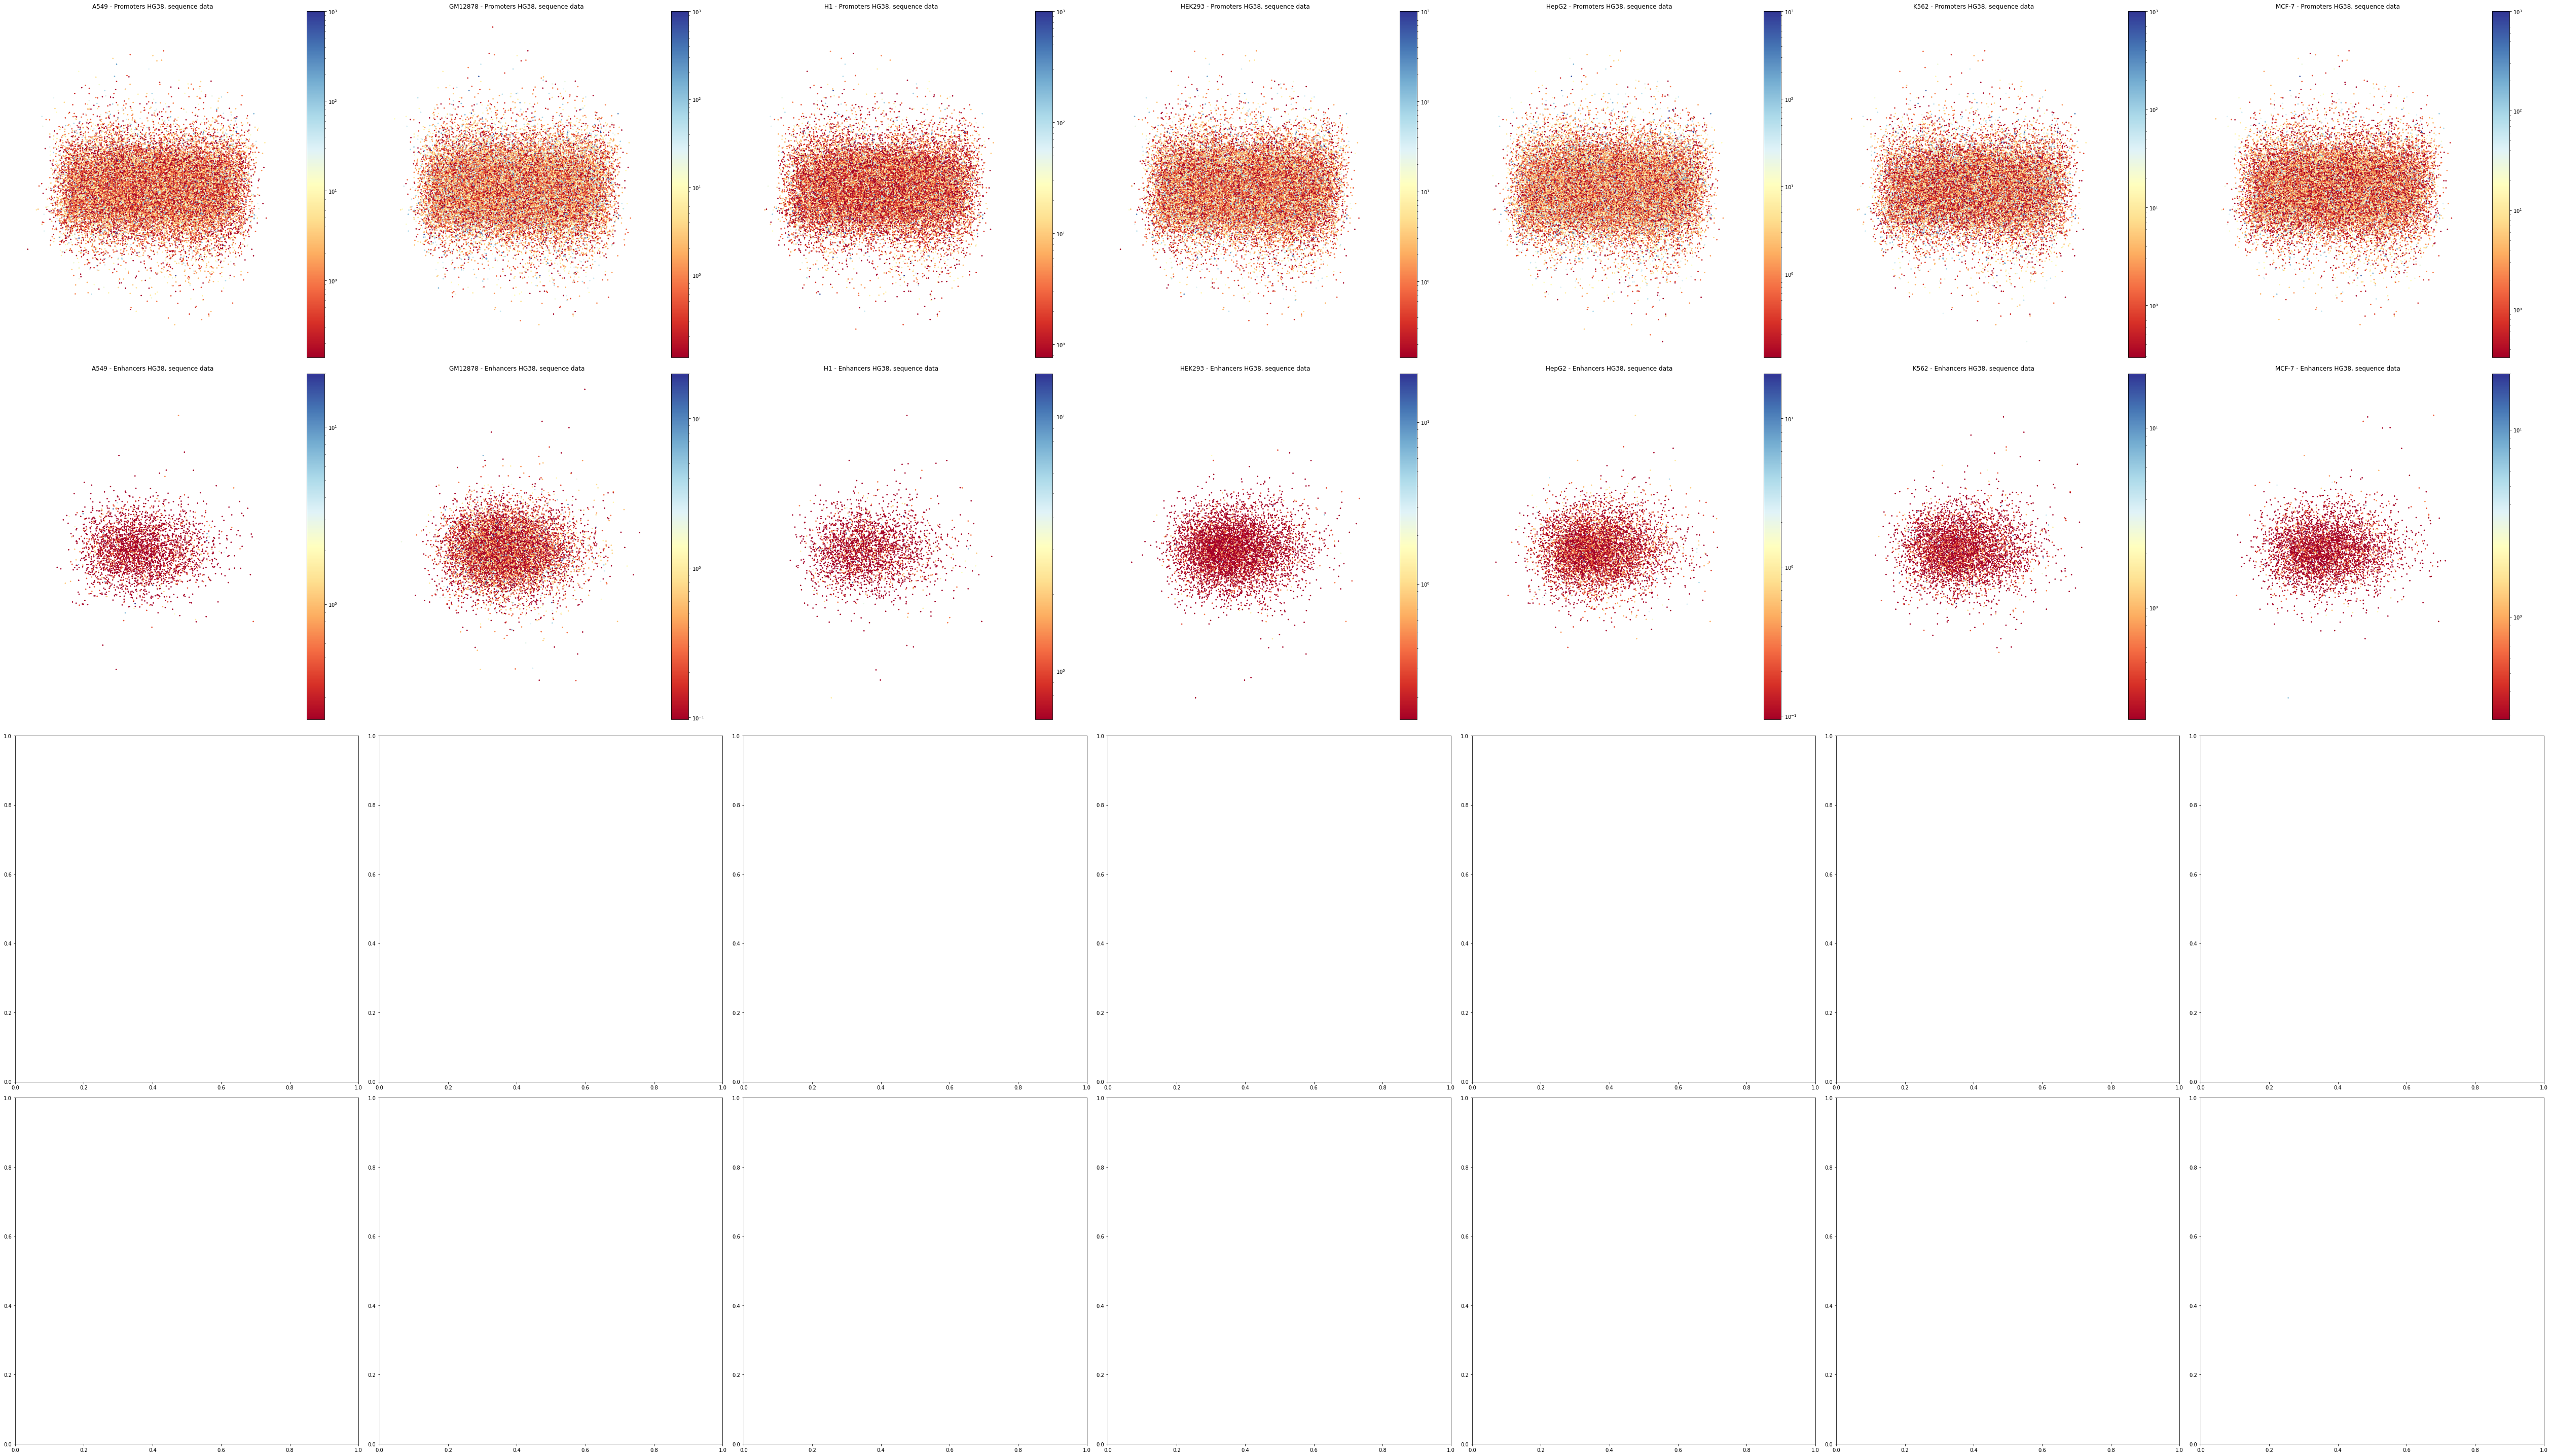

In [38]:
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers, active_promoters_vs_inactive_promoters
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from keras_bed_sequence import BedSequence

epigenomic_fig, epigenomic_axes = plt.subplots(
    nrows=8,
    ncols=len(get_cell_lines()),
    figsize=(10*len(get_cell_lines()), 80),
    squeeze=False
)

sequence_fig, sequence_axes = plt.subplots(
    nrows=4,
    ncols=len(get_cell_lines()),
    figsize=(10*len(get_cell_lines()), 40),
    squeeze=False
)

for i, cell_line in enumerate(tqdm(get_cell_lines(), desc="Computing decompositions")):
    for k, metric in enumerate(tqdm(["mean"], desc="Metrics", leave=False)):
        for l, decomposition_method in enumerate(tqdm([get_pca_decomposition], desc="Decomposition method", leave=False)):
            for j, ((epigenomic, scores), region, clip_value) in enumerate(tqdm((
                (active_promoters_vs_inactive_promoters(cell_line=cell_line, metric=metric), "Promoters", 1000),
                (active_enhancers_vs_inactive_enhancers(cell_line=cell_line, metric=metric), "Enhancers", 20)
            ), desc="Task", leave=False)):
                # imputation and scaling of the data
                imputed_epigenomic = pd.DataFrame(
                    MinMaxScaler().fit_transform(
                        KNNImputer().fit_transform(epigenomic)
                    ),
                    columns=epigenomic.columns,
                    index=epigenomic.index
                )
                decomposed_epigenomic = decomposition_method(
                    imputed_epigenomic,
                    "epigenomic",
                    region,
                    cell_line,
                    metric
                )
                scores[scores>clip_value] = clip_value
                scatter_with_heatmap(
                    decomposition=decomposed_epigenomic,
                    scores=scores.values,
                    figure=epigenomic_fig,
                    ax=epigenomic_axes[j + 2*k + l*4][i]
                )
                epigenomic_axes[j + 2*k + l*4][i].set_title(f"{cell_line} - {region} {metric} HG38, epigenomic data")
                epigenomic_axes[j + 2*k + l*4][i].set_axis_off()
                
                if k==0:
                    sequence = pd.DataFrame(
                        np.array(BedSequence(
                            genome,
                            bed=to_bed(scores),
                            batch_size=1
                        )).reshape(-1, 4*256),
                        index=scores.index
                    )
                    decomposed_sequence = decomposition_method(
                        sequence,
                        "sequence",
                        region,
                        cell_line,
                        metric="None",
                        # It would be better to use the COSINE distance,
                        # but it is too terribly slow to be feaseable
                        # with all the considered use cases.
                        # distance_metric="cosine"
                    )
                    scatter_with_heatmap(
                        decomposition=decomposed_sequence,
                        scores=scores.values,
                        figure=sequence_fig,
                        ax=sequence_axes[j + l*2][i]
                    )
                    sequence_axes[j + l*2][i].set_title(f"{cell_line} - {region} HG38, sequence data")
                    sequence_axes[j + l*2][i].set_axis_off()

epigenomic_fig.tight_layout()
sequence_fig.tight_layout()
plt.show()